## 1. 데이터 준비와 확인

## 2. 데이터로더 구성

## 3. 모델구성을 위한 데이터 분석 및 가공
 - 데이터셋 내 문장 길이 분포
 - 적절한 최대 문장 길이 지정
 - keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
 
 
## 4. 모델구성 및 validation set 구성
 - 3가지 이상
 
## 5. 모델 훈련

## 6. Loss, Accuracy 그래프 시각화

## 7. 학습된 Embedding 레이어 분석

## 8 . 한국어 Word2Vec 임베딩 활용하여 성능개선

 - 한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

https://github.com/Kyubyong/wordvectors

## 1. 데이터 준비와 확인
```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentimental_classification
```

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터 로더 구성

 - 데이터의 중복 제거
 - NaN 결측치 제거
 - 한국어 토크나이저로 토큰화
 - 불용어(Stopwords) 제거
 - 사전word_to_index 구성
 - 텍스트 스트링을 사전 인덱스 스트링으로 변환
 - X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도',
             '를','으로','자','에','와','한','하다','다','고','하','을','.','..',
             ',','었','만','는데','로','음','것','아','네요','어','같','했','에서','기','네','거'
             ,'수','되','면','게','지','있','나','점','인','주','내','~','던','어요','할','겠','1'
             ,'해','습니다','...','더','라','그','볼']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

###상위 100개 에서 불용어 제거하기
for i in range(50):
    print(index_to_word[i])

<PAD>
<BOS>
<UNK>
<UNUSED>
영화
보
!
없
?
좋
너무
봤
적
안
정말
재밌
지만
진짜
않
았
ㅋㅋ
말
연기
최고
평점
이런
왜
스토리
ㅋㅋㅋ
드라마
생각
아니
싶
사람
듯
때
감동
함
배우
본
까지
뭐
알
만들
내용
감독
보다
그냥
재미
시간


In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 4 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  11.119909490680305
문장길이 최대 :  115
문장길이 표준편차 :  8.994011651277654
pad_sequences maxlen :  47
전체 문장의 0.9969796098065414%가 maxlen 설정값 이내에 포함됩니다. 


#### pre padding이 더 성능이 좋다.
#### RNN 은 뒤로 갈 수록 앞의 데이터가 쌓이게 되는데, 최종 state값에 가장 영향을 많이 미친다.
#### 뒤의 데이터가 0이면 끝에 가서 데이터의 의미가 더 줄어들게 된다.
#### 따라서 앞에 부분을 0으로 Padding하는것이 좋다.

In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 47)


## 4. 모델구성 및 validation set 구성
 - 3가지 이상
 
 
 #### 4-1. LSTM

In [7]:
vocab_size = 100000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 47  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


model_LSTM = keras.Sequential()
# [[YOUR CODE]]
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_LSTM.add(keras.layers.Dense(8, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 47)          4700000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               90112     
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 4,791,153
Trainable params: 4,791,153
Non-trainable params: 0
_________________________________________________________________


#### 4-2.   1-D CNN

In [8]:
model_1DCNN = keras.Sequential()
model_1DCNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1DCNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_1DCNN.add(keras.layers.MaxPooling1D(5))
model_1DCNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_1DCNN.add(keras.layers.GlobalMaxPooling1D())
model_1DCNN.add(keras.layers.Dense(8, activation='relu'))
model_1DCNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1DCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 47)          4700000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          5280      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### 4-3.  GlobalMaxPooling1D

In [9]:
model_GlobMaxPool = keras.Sequential()
model_GlobMaxPool.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GlobMaxPool.add(keras.layers.GlobalMaxPooling1D())
model_GlobMaxPool.add(keras.layers.Dense(8, activation='relu'))
model_GlobMaxPool.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GlobMaxPool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 47)          4700000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 47)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 384       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 4,700,393
Trainable params: 4,700,393
Non-trainable params: 0
_________________________________________________________________


#### Validation Set

In [10]:
# validation set 46182건 분리
X_val = X_train[:46182]   
y_val = y_train[:46182]

# validation set을 제외한 나머지 100000건
partial_X_train = X_train[46182:]  
partial_y_train = y_train[46182:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(100000, 47)
(100000,)


## 5. Training Model

In [11]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_LSTM = model_LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
196/196 [==============================] - 31s 157ms/step - loss: 0.4811 - accuracy: 0.7734 - val_loss: 0.3608 - val_accuracy: 0.8424
Epoch 2/10
196/196 [==============================] - 30s 151ms/step - loss: 0.3397 - accuracy: 0.8558 - val_loss: 0.3544 - val_accuracy: 0.8449
Epoch 3/10
196/196 [==============================] - 29s 150ms/step - loss: 0.3177 - accuracy: 0.8670 - val_loss: 0.3537 - val_accuracy: 0.8462
Epoch 4/10
196/196 [==============================] - 29s 150ms/step - loss: 0.3037 - accuracy: 0.8736 - val_loss: 0.3561 - val_accuracy: 0.8466
Epoch 5/10
196/196 [==============================] - 29s 150ms/step - loss: 0.2889 - accuracy: 0.8815 - val_loss: 0.3616 - val_accuracy: 0.8449
Epoch 6/10
196/196 [==============================] - 29s 150ms/step - loss: 0.2740 - accuracy: 0.8893 - val_loss: 0.3672 - val_accuracy: 0.8444
Epoch 7/10
196/196 [==============================] - 29s 149ms/step - loss: 0.2573 - accuracy: 0.8971 - val_loss: 0.3803 - val_ac

In [12]:
model_1DCNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_1DCNN = model_1DCNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
196/196 [==============================] - 7s 35ms/step - loss: 0.5371 - accuracy: 0.7225 - val_loss: 0.4038 - val_accuracy: 0.8122
Epoch 2/8
196/196 [==============================] - 7s 35ms/step - loss: 0.3699 - accuracy: 0.8357 - val_loss: 0.3926 - val_accuracy: 0.8207
Epoch 3/8
196/196 [==============================] - 7s 35ms/step - loss: 0.3233 - accuracy: 0.8602 - val_loss: 0.3965 - val_accuracy: 0.8211
Epoch 4/8
196/196 [==============================] - 7s 34ms/step - loss: 0.2806 - accuracy: 0.8820 - val_loss: 0.4140 - val_accuracy: 0.8192
Epoch 5/8
196/196 [==============================] - 6s 32ms/step - loss: 0.2361 - accuracy: 0.9039 - val_loss: 0.4479 - val_accuracy: 0.8153
Epoch 6/8
196/196 [==============================] - 6s 32ms/step - loss: 0.1939 - accuracy: 0.9241 - val_loss: 0.4928 - val_accuracy: 0.8112
Epoch 7/8
196/196 [==============================] - 6s 32ms/step - loss: 0.1578 - accuracy: 0.9392 - val_loss: 0.5490 - val_accuracy: 0.8085
Epoch 

In [13]:
model_GlobMaxPool.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_GlobMaxPool = model_GlobMaxPool.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/7
196/196 [==============================] - 5s 28ms/step - loss: 0.5551 - accuracy: 0.7712 - val_loss: 0.3982 - val_accuracy: 0.8284
Epoch 2/7
196/196 [==============================] - 5s 25ms/step - loss: 0.3551 - accuracy: 0.8481 - val_loss: 0.3518 - val_accuracy: 0.8449
Epoch 3/7
196/196 [==============================] - 5s 25ms/step - loss: 0.3038 - accuracy: 0.8738 - val_loss: 0.3469 - val_accuracy: 0.8485
Epoch 4/7
196/196 [==============================] - 5s 25ms/step - loss: 0.2708 - accuracy: 0.8900 - val_loss: 0.3518 - val_accuracy: 0.8495
Epoch 5/7
196/196 [==============================] - 5s 27ms/step - loss: 0.2436 - accuracy: 0.9031 - val_loss: 0.3622 - val_accuracy: 0.8478
Epoch 6/7
196/196 [==============================] - 5s 26ms/step - loss: 0.2186 - accuracy: 0.9155 - val_loss: 0.3770 - val_accuracy: 0.8464
Epoch 7/7
196/196 [==============================] - 5s 24ms/step - loss: 0.1950 - accuracy: 0.9260 - val_loss: 0.3964 - val_accuracy: 0.8454


## 6. Loss, Accuracy 그래프 시각화

In [14]:
results_LSTM = model_LSTM.evaluate(X_test,  y_test, verbose=2)
results_1DCNN = model_1DCNN.evaluate(X_test,  y_test, verbose=2)
results_GlobMaxPool = model_GlobMaxPool.evaluate(X_test,  y_test, verbose=2)
print(results_LSTM)
print(results_1DCNN)
print(results_GlobMaxPool)

1537/1537 - 11s - loss: 0.4479 - accuracy: 0.8356
1537/1537 - 1s - loss: 0.6387 - accuracy: 0.7967
1537/1537 - 1s - loss: 0.4096 - accuracy: 0.8381
[0.4478563964366913, 0.8356286883354187]
[0.638695478439331, 0.7967329025268555]
[0.40962332487106323, 0.838090181350708]


In [15]:
history__LSTM_dict = history_LSTM.history
history__1DCNN_dict = history_1DCNN.history
history__GlobMaxPool_dict = history_GlobMaxPool.history
print(history__LSTM_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
print(history__1DCNN_dict.keys())
print(history__GlobMaxPool_dict.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


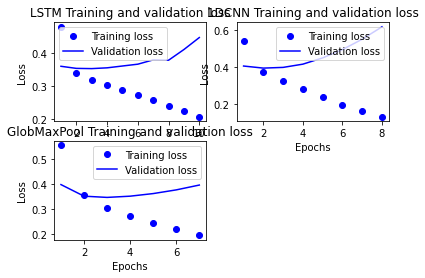

In [16]:
import matplotlib.pyplot as plt

acc_LSTM = history__LSTM_dict['accuracy']
val_acc_LSTM = history__LSTM_dict['val_accuracy']
loss_LSTM = history__LSTM_dict['loss']
val_loss_LSTM = history__LSTM_dict['val_loss']

acc_1DCNN = history__1DCNN_dict['accuracy']
val_acc_1DCNN = history__1DCNN_dict['val_accuracy']
loss_1DCNN = history__1DCNN_dict['loss']
val_loss_1DCNN = history__1DCNN_dict['val_loss']

acc_GlobMaxPool = history__GlobMaxPool_dict['accuracy']
val_acc_GlobMaxPool= history__GlobMaxPool_dict['val_accuracy']
loss_GlobMaxPool = history__GlobMaxPool_dict['loss']
val_loss_GlobMaxPool = history__GlobMaxPool_dict['val_loss']

epochs_LSTM = range(1, len(acc_LSTM) + 1)
epochs_1DCNN = range(1, len(acc_1DCNN) + 1)
epochs_GlobMaxPool = range(1, len(acc_GlobMaxPool) + 1)


# "bo"는 "파란색 점"입니다
plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_LSTM, loss_LSTM, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_LSTM, val_loss_LSTM, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,2,2)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_1DCNN, loss_1DCNN, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_1DCNN, val_loss_1DCNN, 'b', label='Validation loss')
plt.title('1DCNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,2,3)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_GlobMaxPool, loss_GlobMaxPool, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_GlobMaxPool, val_loss_GlobMaxPool, 'b', label='Validation loss')
plt.title('GlobMaxPool Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

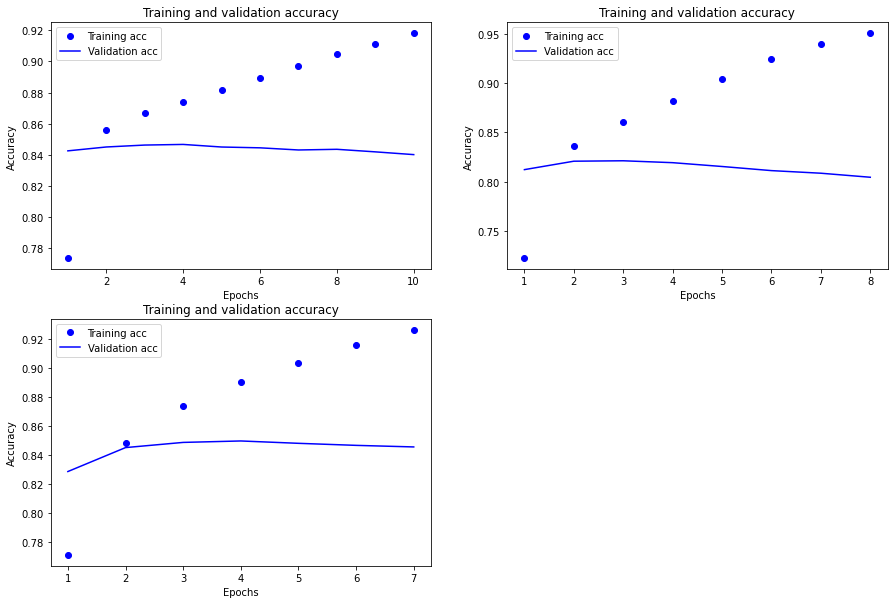

In [17]:
plt.clf()   # 그림을 초기화합니다

plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_LSTM, acc_LSTM, 'bo', label='Training acc')
plt.plot(epochs_LSTM, val_acc_LSTM, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_1DCNN, acc_1DCNN, 'bo', label='Training acc')
plt.plot(epochs_1DCNN, val_acc_1DCNN, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,3)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_GlobMaxPool, acc_GlobMaxPool, 'bo', label='Training acc')
plt.plot(epochs_GlobMaxPool, val_acc_GlobMaxPool, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. 학습된 Embedding 레이어 분석

- 1. 가장 많이 쓰인 단어를 Sort 하고 그 중 많이 쓰인 Top100의 불용어를 추가하였다.

- 2. Train set = 100000, Test set = 46000 개로 설정하였다.

- 3. Maxlen = 47로, Model의 Feature를 47로 설정하였다.

- 4. 3개의 모델 모두 Epoch가 2~3 이상이면 오버피팅했다.

- 5. Data는 많지만 Model이 Shallow 해서 성능이 잘 안올라 가는 것으로 분석된다.

## 8.  한국어 Word2Vec 임베딩 활용하여 성능개선
 - 한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.
https://github.com/Kyubyong/wordvectors

In [92]:
import os
from gensim.models import KeyedVectors
import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [93]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도',
             '를','으로','자','에','와','한','하다','다','고','하','을','.','..',
             ',','었','만','는데','로','음','것','아','네요','어','같','했','에서','기','네','거'
             ,'수','되','면','게','지','있','나','점','인','주','내','~','던','어요','할','겠','1'
             ,'해','습니다','...','더','라','그','볼','!','?','보','았','영화','적','듯','때'
            ,'함','본','까지','뭐','알','감독','내용','중','년','였','서','2','라고','야','니','면서'
            ,'이거','하나','해서','임','3','입니다','라는','다는' ]



vocab_size = 30185
word_vector_dim = 200

def load_data(train_data, test_data, num_words=vocab_size):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(vocab_size-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [94]:
index_to_word = {index:word for word, index in word_to_index.items()}
for i in range(10):
    print(index_to_word[i])

<PAD>
<BOS>
<UNK>
<UNUSED>
없
좋
너무
봤
안
정말


In [95]:
import numpy as np

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [96]:
from keras.initializers import Constant


vocab_size = 30185
word_vector_dim = 200

# 모델 구성
model_1DCNN = keras.Sequential()
model_1DCNN.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_1DCNN.add(keras.layers.Conv1D(64, 7, activation='relu'))
model_1DCNN.add(keras.layers.Conv1D(64, 7, activation='relu'))
model_1DCNN.add(keras.layers.MaxPooling1D())
model_1DCNN.add(keras.layers.Conv1D(128, 7, activation='relu'))
model_1DCNN.add(keras.layers.Conv1D(256, 7, activation='relu'))
model_1DCNN.add(keras.layers.GlobalMaxPooling1D())
model_1DCNN.add(keras.layers.Dense(16, activation='relu'))
model_1DCNN.add(keras.layers.Dense(1, activation='sigmoid')) 

model_1DCNN.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 47, 200)           6037000   
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 41, 64)            89664     
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 35, 64)            28736     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 17, 64)            0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 11, 128)           57472     
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 5, 256)            229632    
_________________________________________________________________
global_max_pooling1d_24 (Glo (None, 256)             

In [97]:
# 학습의 진행
from keras import optimizers

Adam = optimizers.Adam(lr=0.00003)

model_1DCNN.compile(optimizer=Adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_1DCNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
196/196 [==============================] - 22s 111ms/step - loss: 0.6935 - accuracy: 0.5121 - val_loss: 0.6911 - val_accuracy: 0.5178
Epoch 2/15
196/196 [==============================] - 21s 107ms/step - loss: 0.6874 - accuracy: 0.5451 - val_loss: 0.6807 - val_accuracy: 0.5704
Epoch 3/15
196/196 [==============================] - 21s 107ms/step - loss: 0.6661 - accuracy: 0.5921 - val_loss: 0.6521 - val_accuracy: 0.6099
Epoch 4/15
196/196 [==============================] - 21s 106ms/step - loss: 0.6350 - accuracy: 0.6360 - val_loss: 0.6252 - val_accuracy: 0.6517
Epoch 5/15
196/196 [==============================] - 21s 107ms/step - loss: 0.6082 - accuracy: 0.6653 - val_loss: 0.6063 - val_accuracy: 0.6632
Epoch 6/15
196/196 [==============================] - 21s 107ms/step - loss: 0.5867 - accuracy: 0.6856 - val_loss: 0.5955 - val_accuracy: 0.6635
Epoch 7/15
196/196 [==============================] - 21s 106ms/step - loss: 0.5684 - accuracy: 0.7020 - val_loss: 0.5806 - val_ac

In [98]:
# 모델 구성
model_LSTM = keras.Sequential()
# [[YOUR CODE]]
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                      embeddings_initializer=Constant(embedding_matrix),
                                      input_length=maxlen, 
                                      trainable=True))
model_LSTM.add(keras.layers.LSTM(512,return_sequences = True ))
model_LSTM.add(keras.layers.LSTM(256,return_sequences = True)) 
model_LSTM.add(keras.layers.LSTM(128,return_sequences = True))#가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습
model_LSTM.add(keras.layers.LSTM(64,return_sequences = False))
model_LSTM.add(keras.layers.Dense(16, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 47, 200)           6037000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 47, 512)           1460224   
_________________________________________________________________
lstm_24 (LSTM)               (None, 47, 256)           787456    
_________________________________________________________________
lstm_25 (LSTM)               (None, 47, 128)           197120    
_________________________________________________________________
lstm_26 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_50 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_51 (Dense)             (None, 1)               

In [99]:
Adam = optimizers.Adam(lr=0.00008)
model_LSTM.compile(optimizer=Adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_LSTM = model_LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
196/196 [==============================] - 266s 1s/step - loss: 0.6458 - accuracy: 0.6122 - val_loss: 0.5769 - val_accuracy: 0.7023
Epoch 2/10
196/196 [==============================] - 257s 1s/step - loss: 0.5343 - accuracy: 0.7276 - val_loss: 0.4929 - val_accuracy: 0.7549
Epoch 3/10
196/196 [==============================] - 264s 1s/step - loss: 0.4669 - accuracy: 0.7752 - val_loss: 0.4530 - val_accuracy: 0.7840
Epoch 4/10
196/196 [==============================] - 260s 1s/step - loss: 0.4300 - accuracy: 0.7991 - val_loss: 0.4253 - val_accuracy: 0.8008
Epoch 5/10
196/196 [==============================] - 259s 1s/step - loss: 0.4029 - accuracy: 0.8159 - val_loss: 0.4138 - val_accuracy: 0.8086
Epoch 6/10
196/196 [==============================] - 262s 1s/step - loss: 0.3813 - accuracy: 0.8283 - val_loss: 0.3922 - val_accuracy: 0.8228
Epoch 7/10
196/196 [==============================] - 263s 1s/step - loss: 0.3627 - accuracy: 0.8393 - val_loss: 0.4166 - val_accuracy: 0.8087

In [100]:
model_GlobMaxPool = keras.Sequential()
model_GlobMaxPool.add(keras.layers.Embedding(vocab_size, word_vector_dim, 
                                             input_length=maxlen, 
                                             trainable=True))
model_GlobMaxPool.add(keras.layers.GlobalMaxPooling1D())
model_GlobMaxPool.add(keras.layers.Dense(4, activation='relu'))
model_GlobMaxPool.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GlobMaxPool.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 47, 200)           6037000   
_________________________________________________________________
global_max_pooling1d_25 (Glo (None, 200)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 4)                 804       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 5         
Total params: 6,037,809
Trainable params: 6,037,809
Non-trainable params: 0
_________________________________________________________________


In [101]:
Adam = optimizers.Adam(lr=0.0001)
model_GlobMaxPool.compile(optimizer=Adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_GlobMaxPool = model_GlobMaxPool.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 9s 45ms/step - loss: 0.6895 - accuracy: 0.7200 - val_loss: 0.6841 - val_accuracy: 0.7924
Epoch 2/20
196/196 [==============================] - 9s 46ms/step - loss: 0.6684 - accuracy: 0.7914 - val_loss: 0.6492 - val_accuracy: 0.8012
Epoch 3/20
196/196 [==============================] - 9s 46ms/step - loss: 0.6229 - accuracy: 0.8115 - val_loss: 0.5950 - val_accuracy: 0.8112
Epoch 4/20
196/196 [==============================] - 9s 44ms/step - loss: 0.5612 - accuracy: 0.8237 - val_loss: 0.5311 - val_accuracy: 0.8192
Epoch 5/20
196/196 [==============================] - 9s 45ms/step - loss: 0.4971 - accuracy: 0.8323 - val_loss: 0.4739 - val_accuracy: 0.8255
Epoch 6/20
196/196 [==============================] - 9s 44ms/step - loss: 0.4443 - accuracy: 0.8391 - val_loss: 0.4319 - val_accuracy: 0.8296
Epoch 7/20
196/196 [==============================] - 8s 43ms/step - loss: 0.4060 - accuracy: 0.8448 - val_loss: 0.4040 - val_accuracy: 0.8331

In [102]:
history__LSTM_dict = history_LSTM.history
history__1DCNN_dict = history_1DCNN.history
history__GlobMaxPool_dict = history_GlobMaxPool.history
print(history__LSTM_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
print(history__1DCNN_dict.keys())
print(history__GlobMaxPool_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


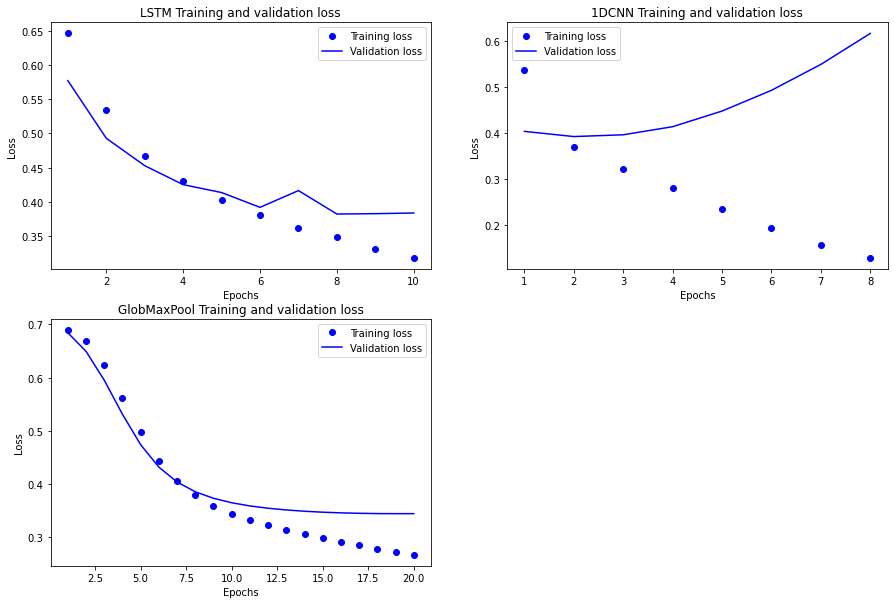

In [103]:
import matplotlib.pyplot as plt

acc_LSTM = history__LSTM_dict['accuracy']
val_acc_LSTM = history__LSTM_dict['val_accuracy']
loss_LSTM = history__LSTM_dict['loss']
val_loss_LSTM = history__LSTM_dict['val_loss']

acc_1DCNN = history__1DCNN_dict['accuracy']
val_acc_1DCNN = history__1DCNN_dict['val_accuracy']
loss_1DCNN = history__1DCNN_dict['loss']
val_loss_1DCNN = history__1DCNN_dict['val_loss']

acc_GlobMaxPool = history__GlobMaxPool_dict['accuracy']
val_acc_GlobMaxPool= history__GlobMaxPool_dict['val_accuracy']
loss_GlobMaxPool = history__GlobMaxPool_dict['loss']
val_loss_GlobMaxPool = history__GlobMaxPool_dict['val_loss']

epochs_LSTM = range(1, len(acc_LSTM) + 1)
epochs_1DCNN = range(1, len(acc_1DCNN) + 1)
epochs_GlobMaxPool = range(1, len(acc_GlobMaxPool) + 1)


# "bo"는 "파란색 점"입니다
plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_LSTM, loss_LSTM, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_LSTM, val_loss_LSTM, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,2,2)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_1DCNN, loss_1DCNN, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_1DCNN, val_loss_1DCNN, 'b', label='Validation loss')
plt.title('1DCNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,2,3)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_GlobMaxPool, loss_GlobMaxPool, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_GlobMaxPool, val_loss_GlobMaxPool, 'b', label='Validation loss')
plt.title('GlobMaxPool Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

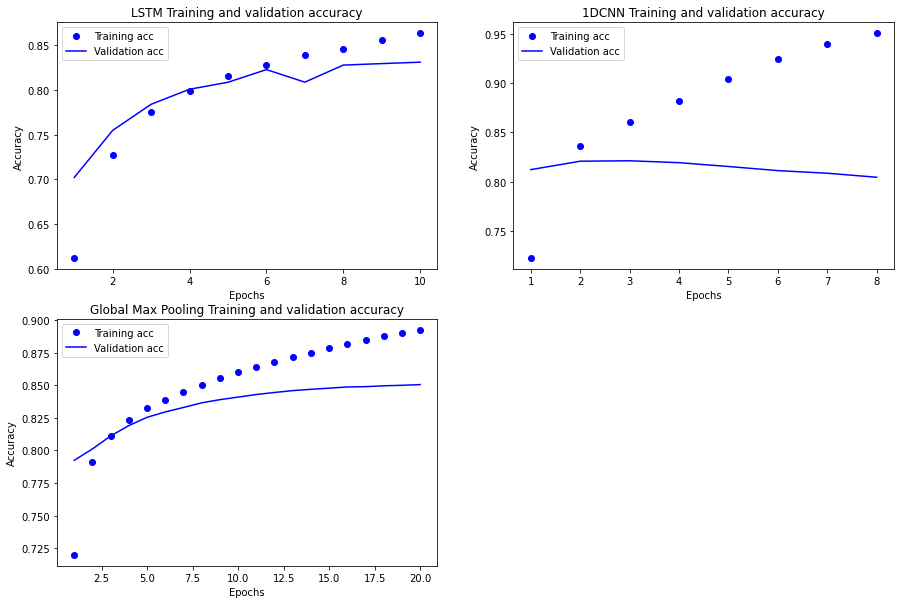

In [104]:
plt.clf()   # 그림을 초기화합니다

plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_LSTM, acc_LSTM, 'bo', label='Training acc')
plt.plot(epochs_LSTM, val_acc_LSTM, 'b', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_1DCNN, acc_1DCNN, 'bo', label='Training acc')
plt.plot(epochs_1DCNN, val_acc_1DCNN, 'b', label='Validation acc')
plt.title('1DCNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,3)
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(epochs_GlobMaxPool, acc_GlobMaxPool, 'bo', label='Training acc')
plt.plot(epochs_GlobMaxPool, val_acc_GlobMaxPool, 'b', label='Validation acc')
plt.title('Global Max Pooling Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1. Epochs 가 3 근처에서 Overfitting 이 일어났다. Learning rate 를 0.001 --> 0.0001 까지 조정해본 결과
 - Adam 이 minimum을 너무 잘 찾는진 모르겠지만, 큰 차이는 없었다.

### 2. 불용어를 30개 정도 추가했다. -->  Validation Accuracy 에 큰 차이가 없었다.

### 3. LSTM의 벡터를 늘려 여러층 쌓고, Conv1D도 여러층 쌓고 벡터를 늘렸다. --> Validation Accuracy에 큰 차이가 없었다.

## 결론 :  Train 시간도 가장 짧고 모델의 구조가 가장 간단한 Global Max Pooling 모델이 성능이 좋은걸로 판별이 났다.


### 의문점 1. 이론상으로는 LSTM이 가장 성능이 좋아야 하는데, 왜 그럴까.. 모델을 변경해 보며 실험을 진행해 봐야겠다.

### 의문점 2. 별짓을 다해도 성능이 85% 이상 올라가지 않는다. 도대체 왜..

### 의문점 3. 불용어를 추가한것과 추가하지 않은것의 성능 차이가 크지 않았다. 왜...